# 自己紹介
竹田航太

所属: 京都大学 大学院理学研究科 数学教室

専攻: 応用数学

興味: 流体，UQ(Uncertainty Quantification)， データ同化，機械学習，気象予報

# RCCS オンラインスクール課題

課題

1. Lorenz-96を4次のRunge-Kutta法を用いて実装する。パラメータ値Fをいろいろ変え、F=8の時にカオスとなることを確認する。
余裕があれば、他の時間積分スキームも実装してみる。
2. パラメータ値F=8とする。誤差の平均発達率について調べ、0.2時間ステップを1日と定義することの妥当性を確認する。
3. 2年分積分し、最初の1年分をスピンアップとして捨てる。後半1年分を6時間毎に保存しておく。
4. Mersenne Twister等の性質の良い乱数生成プログラムを用いて分散1の正規分布乱数を生成する。
ヒストグラム等で意図した乱数が生成されていることを確認する。
その上で、３で保存した6時間毎の状態に足しこんで、別途保存する。これを観測データとする。
5. 6時間サイクルのデータ同化システムを構築する。Kalman Filter (KF)の式を直接解くものでよい。
ただし、KFの予報誤差共分散の部分に定数を入れられるように設計しておく。（定数を入れると、3次元変分法と同値である）。
6. 3次元変分法とKFとの比較実験を行う。この際、観測分布への依存性を調べる。また、パラメータ等への依存性も調査し、特徴を調べる。
7. EnKFを実装し、KFとの比較実験を行う。
Whitaker and Hamill (2002, MWR)によるEnSRFや、Bishop et al. (2001, MWR)によるETKF、Hunt et al. (Physica D, 2007)によるLETKF等。
8. 4次元変分法を実装し、比較する。4次元変分法には、アジョイントモデルを構築するほか、近似的に40x40行列の線形モデルを生成する方法もある。
もしアジョイントモデルを構築すれば、近似的な線形モデル行列との違いについて調べてみるのも面白いかもしれない。モデルの非線形性の調査になる。
線形モデルの場合一致することを確認する。
9. 発展的課題：完全モデルを仮定してきたが、モデル誤差を導入して同様の調査を行ってみる。

参考リンク
- 三好による京都大学での講義 (要パスワード)
- Lorenz and Emanuel, 1998: Optimal sites for supplementary weather observations:Simulation with a small model. J. Atmos. Sci., 55, 399−414.
- Whitaker and Hamill, 2002: Ensemble data assimilation without perturbedobservations. Mon. Wea. Rev., 130, 1913‒1924.
- Bishop et al., 2001: Adaptive sampling with the ensembletransform Kalman filter. Part I: Theoretical aspects. Mon. Wea. Rev., 129, 420‒436.
- Hunt et al., 2007: Efficient data assimilation forspatiotemporal chaos: A local ensemble transform Kalman filter, Physica D, 230, 112‒126.


## 準備

In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# モジュールの読み込み
import sys
sys.path.append('./')
from utils import make_lorenz96, rk4, euler

## 1. Lorenz-96を4次のRunge-Kutta法を用いて実装する。パラメータ値Fをいろいろ変え、F=8の時にカオスとなることを確認する。余裕があれば、他の時間積分スキームも実装してみる。

### 計算の準備
初期値: 
$ X_j = F $とし，摂動として$ X_{20} $に$ 1.001 $をかける．
$ X_{20} = F \cdot 1.001$

以下を参考にした．
- Lorenz and Emanuel, 1998: Optimal sites for supplementary weather observations:Simulation with a small model. J. Atmos. Sci., 55, 399−414.

以下の2種類のplotを行う．
- 摂動を加えた20番目の要素をplot
- 1,2,3番目の要素を3次元plot


In [19]:
# J: 変数の数
J = 40

# 外力
F = 8

# 初期値の設定(摂動を加える)
x0 = F*np.ones(J)
x0[19] *= 1.001

# dt: 時間刻み
dt = 0.01

# N: 時間ステップ数
# 天下り的ではあるが1年分に相当
N = 360*20

# 任意のスキームでLorenz96を計算，plotする．
# 引数: scheme(t, x, dt, f) -> df
def simulate_lorenz96(scheme, plot=True):
    result = np.zeros((N,J))
    x = x0
    result[0] = x[:]

    for n in range(1,N):
        t = n*dt
        x = scheme(t, x, dt, lorenz)
        result[n] = x[:]
        
#  plot
    if plot:
        fig1, ax1 = plt.subplots()

        # 摂動を加えた20番目の要素をplot
        ax1.plot(result[:, 19])
        ax1.set_xlabel('step')
        ax1.set_ylabel('$x_{20} $')
        plt.title('plot 20th component')

        # 1,2,3番目の要素を3次元plot
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot(result[:, 0], result[:, 1], result[:, 2])
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_zlabel('$x_3$')
        plt.title('first three components of Lorenz96')
        plt.show()

    return result

### 4次RungeKuttaでの計算結果

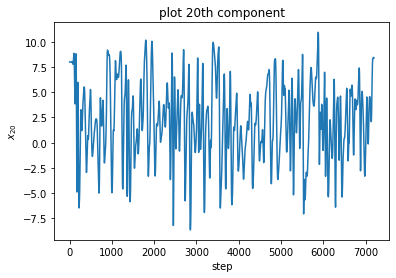

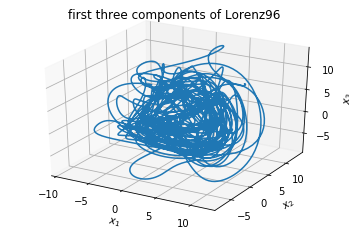

In [3]:
lorenz = make_lorenz96(F)
x = simulate_lorenz96(rk4)

## 2. パラメータ値F=8とする。誤差の平均発達率について調べ、0.2時間ステップを1日と定義することの妥当性を確認する。

### 方針
- rmseの平均発達率を調べる．
- リヤプノフ指数を数値的に近似計算することによって誤差の平均発達率を評価する．

### 結果

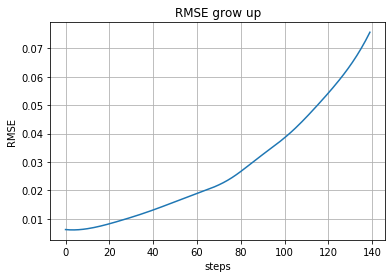

In [15]:
# step数
# 天下り的ではあるが１週間分
Nstep = 7*20

# サンプル数
M = 180//7

# 時間刻み幅
dt = 0.01

# 摂動の大きさ
epsilon = 1e-3

error = np.zeros((M,Nstep))
np.random.seed(1)

for m in range(M):
#     半分以降の軌道からサンプル
    z = x[180*20+7*20*m, :]
    z_perturb = z + epsilon*np.random.normal(size=z.shape)
    error[m, 0] = np.linalg.norm(z - z_perturb, ord=2)
    
    for n in range(1, Nstep):
        t = n*dt
        z = rk4(t, z, dt, lorenz)
        z_perturb = rk4(t, z_perturb, dt, lorenz)
        error[m, n] = np.linalg.norm(z - z_perturb, ord=2)

error_mean = error.mean(axis=0)

# plot
fig, ax = plt.subplots()
ax.plot(error_mean)
ax.set_xlabel('steps')
ax.set_ylabel('RMSE')
plt.grid()
_ = plt.title('RMSE grow up')

# # logを取ったものもplot
# fig1, ax1 = plt.subplots()
# ax1.plot(np.log(error_mean))
# plt.grid()
# _ = plt.title('log error grow up')

### 1から50step後の誤差の発達率を計算

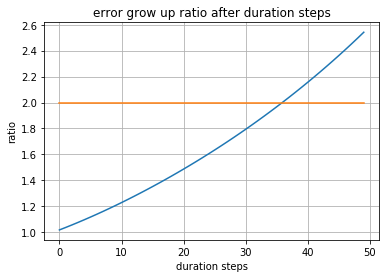

In [18]:
# duration = 40
error_mean_duration = np.array([
    np.array([error_mean[i+duration]/error_mean[i] for i in range(Nstep-duration)]).mean()
    for duration in range(1,51)])

fig, ax = plt.subplots()
ax.plot(error_mean_duration)
ax.plot(2*np.ones(50))
ax.set_xlabel('duration steps')
ax.set_ylabel('ratio')
plt.grid()
_ = plt.title('error grow up ratio after duration steps')

#### 考察
- 約40回(37回くらい)ごとに誤差が2倍になっている．
- 論文によると気象学では2日で誤差が2倍になるとある．

よって$ dt = 0.01 $なので
$ 40 \times 0.01 = 2 day $から
$ 1 day = 0.2 $
と考える．


In [6]:
# F = 4
# x0 = F*np.ones(J)
# x0[19] *= 1.001
# lorenz = make_lorenz96(F)

# simulate_lorenz96(rk4)

In [7]:
# F = 1
# x0 = F*np.ones(J)
# x0[19] *= 1.001
# lorenz = make_lorenz96(F)

# simulate_lorenz96(rk4)

## 3. 2 年分積分し、最初の 1 年分をスピンアップとして捨てる。後半 1 年分を 6 時間毎に保存し ておく。

In [8]:
# # J: 変数の数
# J = 40

# dt: 時間刻み
# 0.05で6h
dt = 0.01

# N: 時間ステップ数
# 2年分に相当
N = 360*2*20

result = simulate_lorenz96(rk4, plot=False)

# スピンアップを捨てる
x_one_year = result[360*20:]

# 6時間ごとを抽出
x_by_6h = x_one_year[::5]

np.save('data/true_atr.npy', x_by_6h)

npy形式で保存

In [9]:
load_true_atr = np.load('data/true_atr.npy')
load_true_atr.shape

(1440, 40)

## 4. Mersenne Twister 等の性質の良い乱数生成プログラムを用いて分散 1 の正規分布乱数を生成 し、3で保存した 6 時間毎の場に足しこんで、別途保存する。これを観測データとする。

(array([2., 0., 3., 8., 6., 6., 4., 5., 2., 4.]),
 array([-2.3015387 , -1.89690365, -1.4922686 , -1.08763356, -0.68299851,
        -0.27836347,  0.12627158,  0.53090663,  0.93554167,  1.34017672,
         1.74481176]),
 <a list of 10 Patch objects>)

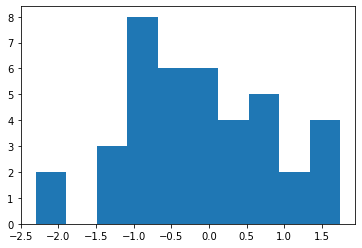

In [10]:
np.random.seed(1)
plt.hist(np.random.randn(J))

In [11]:
np.random.seed(1)
obs_atr = load_true_atr + np.random.normal(size=load_true_atr.shape)
np.save('data/obs_atr.npy', obs_atr)

In [12]:
load_obs_atr = np.load('data/obs_atr.npy')
load_obs_atr

array([[-2.02866929,  3.15307267,  1.45209711, ...,  3.30380219,
         6.89038193,  2.35694042],
       [-3.33920472,  2.82500277,  2.2527566 , ...,  4.33489061,
         5.31496266,  1.0009311 ],
       [-2.79999015,  3.184725  ,  4.1347816 , ...,  2.35641525,
         5.87911368, -0.56401832],
       ...,
       [ 4.86918889,  0.01099259,  0.3317788 , ..., -3.61591063,
        -3.1152589 , 10.14434624],
       [ 7.27831089, -2.89272064,  1.8658861 , ..., -2.07127672,
         0.37754803,  8.30086152],
       [ 7.83480886, -4.84410234, -0.28270258, ..., -0.05930295,
        -1.54267048,  7.57322823]])

Text(0.5, 1.0, 'plot 20th component')

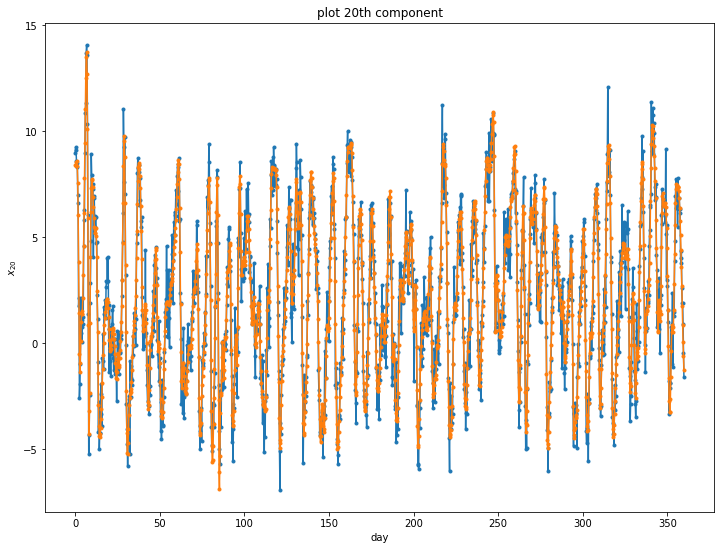

In [13]:
dates = [time/4 for time in range(1440)]
fig1, ax1 = plt.subplots(figsize=(12,9))
ax1.plot(dates, load_obs_atr[:, 19], '.-', label='obs')
ax1.plot(dates, load_true_atr[:, 19],'.-', label='true')
ax1.set_xlabel('day')
ax1.set_ylabel('$x_{20} $')
plt.title('plot 20th component')
#plt.legend()

## 5. 6時間サイクルのデータ同化システムを構築する。Kalman Filter (KF)の式を直接解くものでよい。
ただし、KFの予報誤差共分散の部分に定数を入れられるように設計しておく。（定数を入れると、3次元変分法と同値である）。


## 6. 3次元変分法とKFとの比較実験を行う。この際、観測分布への依存性を調べる。また、パラメータ等への依存性も調査し、特徴を調べる。


## 7. EnKFを実装し、KFとの比較実験を行う。
Whitaker and Hamill (2002, MWR)によるEnSRFや、Bishop et al. (2001, MWR)によるETKF、Hunt et al. (Physica D, 2007)によるLETKF等。


## 8. 4次元変分法を実装し、比較する。4次元変分法には、アジョイントモデルを構築するほか、近似的に40x40行列の線形モデルを生成する方法もある。
もしアジョイントモデルを構築すれば、近似的な線形モデル行列との違いについて調べてみるのも面白いかもしれない。モデルの非線形性の調査になる。
線形モデルの場合一致することを確認する。


## 9. 発展的課題：完全モデルを仮定してきたが、モデル誤差を導入して同様の調査を行ってみる。

## 参考
- Lorenz and Emanuel, 1998: Optimal sites for supplementary weather observations:Simulation with a small model. J. Atmos. Sci., 55, 399−414.
- [Lorenz96モデルのデータ同化:準備編](https://qiita.com/litharge3141/items/41b8dd3104413529407f)